**Corona Viruses**

The 2019–20 coronavirus pandemic is an ongoing pandemic of coronavirus disease 2019 (COVID-19) caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The virus was first reported in Wuhan, Hubei, China on 17 November 2019,[1] and on 11 March 2020, the World Health Organization (WHO) declared the outbreak a pandemic.[4] As of 13 March 2020, over 144,000 cases have been confirmed in more than 130 countries and territories, with major outbreaks in mainland China, Italy, South Korea, and Iran.[2] As of 13 March, at least 5,300 people have died from the disease and more than 70,900 have recovered.[2]

A novel coronavirus (nCoV) is a new strain that has not been previously identified in humans.

*** Source - Wikipedia

Latest status - https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_pandemic#/media/File:COVID-19-outbreak-timeline.gif


**This notebook is mainly drives for a timeseries forecasting for confirmed, death and recovered cases.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from datetime import date, timedelta
from statsmodels.tsa.arima_model import ARIMA
from sklearn.cluster import KMeans
from fbprophet import Prophet

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv
/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv


In [2]:
covid19_df=pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv")
covid19_df = covid19_df.rename(columns={"ObservationDate": "date","Country/Region": "country", "Province/State": "state", "Confirmed":"confirm", "Deaths": "death","Recovered":"recover"})
covid19_df.head()


SNo        date      state         country      Last Update  confirm  \
0    1  01/22/2020      Anhui  Mainland China  1/22/2020 17:00        1   
1    2  01/22/2020    Beijing  Mainland China  1/22/2020 17:00       14   
2    3  01/22/2020  Chongqing  Mainland China  1/22/2020 17:00        6   
3    4  01/22/2020     Fujian  Mainland China  1/22/2020 17:00        1   
4    5  01/22/2020      Gansu  Mainland China  1/22/2020 17:00        0   

   death  recover  
0      0        0  
1      0        0  
2      0        0  
3      0        0  
4      0        0

In [3]:
covid19_df.shape

(4935, 8)

** Exploratory Data Analysis ******

In [4]:
covid19_df.isnull().sum()

SNo               0
date              0
state          1815
country           0
Last Update       0
confirm           0
death             0
recover           0
dtype: int64

Get latest data set as the data is cumulative

In [5]:
daily_df = covid19_df.sort_values(['date', 'country', 'state'])
latest_data = covid19_df[covid19_df.date == daily_df.date.max()]
latest_data.sample(10)

SNo      date     state      country          Last Update  confirm  \
4740  4741  03/11/20       NaN  Netherlands  2020-03-11T14:13:11      503   
4830  4831  03/11/20       NaN   Azerbaijan  2020-03-11T08:13:09       11   
4741  4742  03/11/20       NaN       Sweden  2020-03-11T19:33:02      500   
4805  4806  03/11/20   Georgia           US  2020-03-11T18:52:03       23   
4908  4909  03/11/20       NaN       Jordan  2020-03-03T15:33:02        1   
4818  4819  03/11/20    Oregon           US  2020-03-11T22:53:03       19   
4831  4832  03/11/20       NaN       Brunei  2020-03-11T22:13:12       11   
4785  4786  03/11/20       NaN      Finland  2020-03-11T13:33:10       59   
4917  4918  03/11/20  Delaware           US  2020-03-11T23:13:06        1   
4825  4826  03/11/20       NaN      Hungary  2020-03-11T22:13:12       13   

      death  recover  
4740      5        0  
4830      0        3  
4741      1        1  
4805      0        0  
4908      0        0  
4818      0        0  
4831      0        0  
4785      0        1  
4917      0        0  
4825      0        0

Rename columns select desired column list for the latest data set

In [6]:
columns_list = ["state", "country", "date", "confirm", "death", "recover"]
latest_data = covid19_df[columns_list]
latest_data.sample(10)

state         country        date  confirm  death  \
3513         Providence, RI              US    03/05/20        2      0   
1583                Shaanxi  Mainland China  02/16/2020      236      0   
1726                Sichuan  Mainland China  02/18/2020      508      3   
4650                    NaN          Serbia    03/10/20        5      0   
4101                    NaN         Belarus    03/08/20        6      0   
4258                  Anhui  Mainland China    03/09/20      990      6   
4922                    NaN         Ukraine    03/11/20        1      0   
4494   St. Louis County, MO              US    03/09/20        1      0   
2814  From Diamond Princess       Australia  02/29/2020        0      0   
896                   Tibet  Mainland China    02/06/20        1      0   

      recover  
3513        0  
1583       71  
1726      169  
4650        0  
4101        0  
4258      984  
4922        0  
4494        0  
2814        0  
896         0

In [7]:
latest_data_groupby_country = latest_data.groupby("country")[["confirm", "death", "recover"]].sum().reset_index()
latest_data_groupby_country.sample(5)

country  confirm  death  recover
116    Taiwan     1152     25      206
11    Bahrain     1049      0       83
37    Estonia       80      0        0
77   Mongolia        2      0        0
49    Hungary       48      0        0

Bar plot of confirmed cases on contry level

In [8]:
fig = px.bar(latest_data_groupby_country, 
             y="confirm", x="country", color='country', 
             hover_data = ['confirm', 'death', 'recover'],
             log_y=True, template='ggplot2')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot on Country',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

Bar plot of confirmed cases on a daily level for China

In [9]:
covid19_df['country'].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

In [10]:
fig = px.bar(covid19_df.loc[covid19_df['country'] == 'Mainland China'], x='date', y='confirm', 
             hover_data=['state', 'confirm', 'recover'], color='state', template='ggplot2')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for Mainland China over time',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

Bar plot for recovered cases over country

In [11]:
fig = px.bar(latest_data_groupby_country, 
             y="recover", x="country", color='country', 
             hover_data = ['confirm', 'death', 'recover'],
             log_y=True, template='ggplot2')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Recovered bar plot on Country',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

Bar plot for death on country level

In [12]:
fig = px.bar(latest_data_groupby_country, 
             y="death", x="country", color='country', 
             hover_data = ['confirm', 'death', 'recover'],
             log_y=True, template='ggplot2')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Death bar plot on Country',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

** EDA for Germany**

In [13]:
covid19_df.head()

SNo        date      state         country      Last Update  confirm  \
0    1  01/22/2020      Anhui  Mainland China  1/22/2020 17:00        1   
1    2  01/22/2020    Beijing  Mainland China  1/22/2020 17:00       14   
2    3  01/22/2020  Chongqing  Mainland China  1/22/2020 17:00        6   
3    4  01/22/2020     Fujian  Mainland China  1/22/2020 17:00        1   
4    5  01/22/2020      Gansu  Mainland China  1/22/2020 17:00        0   

   death  recover  
0      0        0  
1      0        0  
2      0        0  
3      0        0  
4      0        0

In [14]:
de_data = covid19_df[covid19_df['country'] == 'Germany']
de_data.tail(5)

SNo      date state  country          Last Update  confirm  death  \
3778  3779  03/07/20   NaN  Germany  2020-03-07T17:43:05      799      0   
4000  4001  03/08/20   NaN  Germany  2020-03-08T21:03:03     1040      0   
4255  4256  03/09/20   NaN  Germany  2020-03-09T18:13:11     1176      2   
4519  4520  03/10/20   NaN  Germany  2020-03-10T18:53:02     1457      2   
4725  4726  03/11/20   NaN  Germany  2020-03-11T19:13:17     1908      3   

      recover  
3778       18  
4000       18  
4255       18  
4519       18  
4725       25

Time series analysis using --- Facebook Prophet on confirmed cases for Germany

Load pandas DF to prophet DF. As the documentation says - the input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast. Hence adjusted the prophet data frame accordingly.

In [15]:
prophet_de_confirmed=de_data.iloc[: , [4,5 ]]
prophet_de_confirmed.head()
prophet_de_confirmed.columns = ['ds','y']
prophet_de_confirmed.head()

ds  y
318    1/28/20 23:00  4
370    1/29/20 19:30  4
426    1/30/20 16:00  4
471  1/31/2020 23:59  5
530   02/01/20 18:33  8

We fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor. Then we call its fit method and pass in the historical dataframe.
Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. We can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.

In [16]:
model_de_confirmed = Prophet()
model_de_confirmed.fit(prophet_de_confirmed)
future_de_confirmed = model_de_confirmed.make_future_dataframe(periods=365)
future_de_confirmed.sample(10)

ds
404 2021-03-07 19:13:17
97  2020-05-04 19:13:17
249 2020-10-03 19:13:17
339 2021-01-01 19:13:17
126 2020-06-02 19:13:17
262 2020-10-16 19:13:17
112 2020-05-19 19:13:17
387 2021-02-18 19:13:17
160 2020-07-06 19:13:17
76  2020-04-13 19:13:17

The predict method will assign each row in future a predicted value which it names that. If we pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column that with the forecast, as well as columns for components and uncertainty intervals.

In [17]:
forecast_de_confirmed=model_de_confirmed.predict(future_de_confirmed)
forecast_de_confirmed.sample(5)

ds        trend   yhat_lower   yhat_upper  trend_lower  \
188 2020-08-03 19:13:17 -2426.513683  3631.885570  4236.310159 -2426.918614   
263 2020-10-17 19:13:17  -928.257289  4856.418991  5485.199898  -928.964877   
75  2020-04-12 19:13:17 -4683.886649  1320.063431  1969.959432 -4683.925420   
273 2020-10-27 19:13:17  -728.489769  5085.861280  5718.790528  -729.255925   
408 2021-03-11 19:13:17  1968.371740  7716.629496  8346.421811  1966.723404   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
188 -2426.091476     6360.037928           6360.037928           6360.037928   
263  -927.504251     6114.917373           6114.917373           6114.917373   
75  -4683.844550     6324.894309           6324.894309           6324.894309   
273  -727.685741     6130.826185           6130.826185           6130.826185   
408  1969.987212     6061.298428           6061.298428           6061.298428   

           daily  daily_lower  daily_upper      weekly  weekly_lower  \
188  6230.823277  6230.823277  6230.823277  129.214651    129.214651   
263  6230.823277  6230.823277  6230.823277 -115.905904   -115.905904   
75   6230.823276  6230.823276  6230.823276   94.071033     94.071033   
273  6230.823277  6230.823277  6230.823277  -99.997092    -99.997092   
408  6230.823277  6230.823277  6230.823277 -169.524848   -169.524848   

     weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
188    129.214651                   0.0                         0.0   
263   -115.905904                   0.0                         0.0   
75      94.071033                   0.0                         0.0   
273    -99.997092                   0.0                         0.0   
408   -169.524848                   0.0                         0.0   

     multiplicative_terms_upper         yhat  
188                         0.0  3933.524245  
263                         0.0  5186.660084  
75                          0.0  1641.007660  
273                         0.0  5402.336416  
408                         0.0  8029.670168

We can now plot the forecast by calling the Prophet.plot method and passing in forecast dataframe.



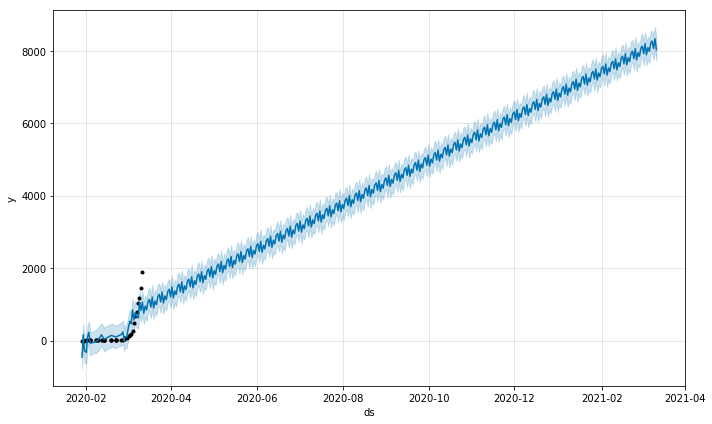

In [18]:
figure_de_confirmed = model_de_confirmed.plot(forecast_de_confirmed)

To see the forecast components, we can use the Prophet.plot_components method. By default we’ll see the trend, yearly seasonality, and weekly seasonality of the time series.

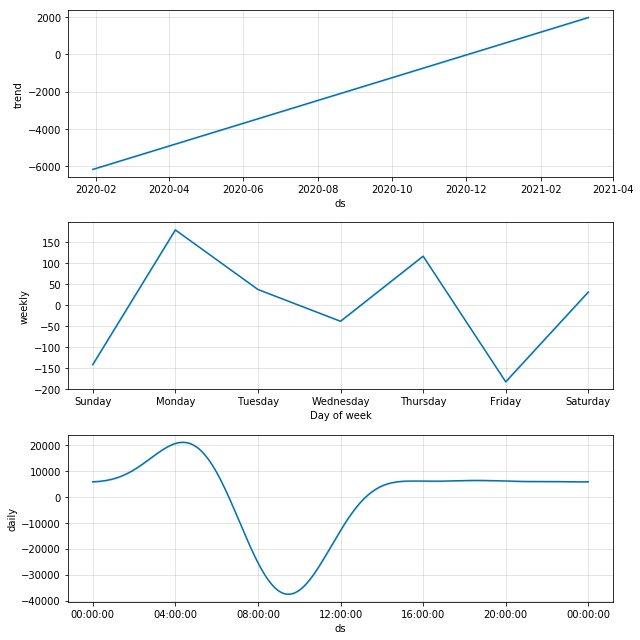

In [19]:
figure_de_confirmed_2 = model_de_confirmed.plot_components(forecast_de_confirmed)

An interactive figure of the forecast can be created with plotly.

In [20]:
py.init_notebook_mode()

figure_de_confirmed_2 = plot_plotly(model_de_confirmed, forecast_de_confirmed)  # This returns a plotly Figure
py.iplot(figure_de_confirmed_2)

** Forecast for recovered cases **

In [21]:
prophet_de_recover=covid19_df.iloc[: , [4,7 ]]
prophet_de_recover.head()
prophet_de_recover.columns = ['ds','y']
prophet_de_recover.tail()

ds  y
4930  2020-03-10T02:33:04  0
4931  2020-03-10T02:33:04  0
4932  2020-03-10T02:33:04  0
4933  2020-03-10T02:33:04  0
4934  2020-03-11T20:53:02  0

In [22]:
model_de_recover=Prophet()
model_de_recover.fit(prophet_de_recover)
future_de_recover=model_de_recover.make_future_dataframe(periods=365)
forecast_de_recover=model_de_recover.predict(prophet_de_recover)
forecast_de_recover.sample(5)

ds       trend   yhat_lower   yhat_upper  trend_lower  \
723  2020-02-01 19:43:03   75.092452 -2706.192598  2776.492095    75.092452   
2143 2020-02-19 01:23:07  172.591358 -2698.086311  2882.570616   172.591358   
3054 2020-02-29 23:13:06  312.139284 -2355.745257  3107.614262   312.139284   
4071 2020-03-07 02:23:08  353.591076 -2536.625643  2972.217593   353.591076   
4379 2020-03-08 18:13:19  364.811906 -2722.273609  2805.515809   364.811906   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
723     75.092452     -209.566432           -209.566432           -209.566432   
2143   172.591358      -98.778976            -98.778976            -98.778976   
3054   312.139284       16.298494             16.298494             16.298494   
4071   353.591076     -178.410100           -178.410100           -178.410100   
4379   364.811906     -208.877759           -208.877759           -208.877759   

           daily  daily_lower  daily_upper     weekly  weekly_lower  \
723  -273.198019  -273.198019  -273.198019  63.631587     63.631587   
2143  -92.588149   -92.588149   -92.588149  -6.190828     -6.190828   
3054  -53.566693   -53.566693   -53.566693  69.865187     69.865187   
4071 -151.289224  -151.289224  -151.289224 -27.120876    -27.120876   
4379 -228.416796  -228.416796  -228.416796  19.539037     19.539037   

      weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
723      63.631587                   0.0                         0.0   
2143     -6.190828                   0.0                         0.0   
3054     69.865187                   0.0                         0.0   
4071    -27.120876                   0.0                         0.0   
4379     19.539037                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
723                          0.0 -134.473981  
2143                         0.0   73.812382  
3054                         0.0  328.437778  
4071                         0.0  175.180976  
4379                         0.0  155.934148

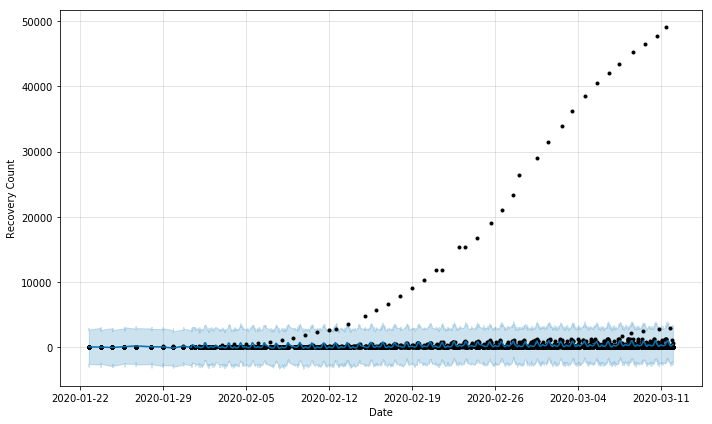

In [23]:
figure_de_recover_1 = plot_plotly(model_de_recover, forecast_de_recover)
py.iplot(figure_de_recover_1) 

figure_de_recover_2 = model_de_recover.plot(forecast_de_recover,xlabel='Date',ylabel='Recovery Count')

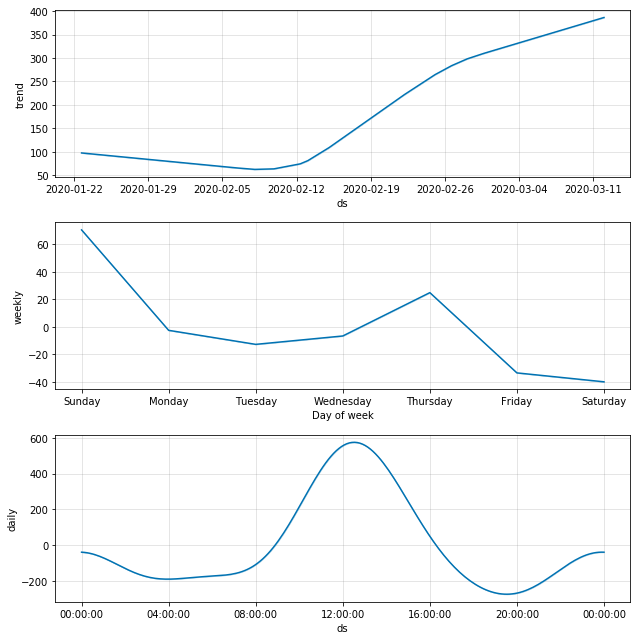

In [24]:
figure_de_recover_3=model_de_recover.plot_components(forecast_de_recover)

** Forecasting for Death**


In [25]:
prophet_de_death = covid19_df.iloc[:, [4, 6]]
prophet_de_death.columns=['ds', 'y']
prophet_de_death.tail(5)

ds  y
4930  2020-03-10T02:33:04  0
4931  2020-03-10T02:33:04  0
4932  2020-03-10T02:33:04  0
4933  2020-03-10T02:33:04  0
4934  2020-03-11T20:53:02  0

In [26]:
model_de_death=Prophet()
model_de_death.fit(prophet_de_death)
future_de_death=model_de_death.make_future_dataframe(periods=365)
forecast_de_death=model_de_death.predict(future_de_death)
forecast_de_death.sample(5)

ds      trend  yhat_lower  yhat_upper  trend_lower  \
4683 2020-03-10 12:53:02  22.559805 -176.569295  319.787962    22.559805   
4007 2020-03-06 23:23:03  22.869376 -214.739955  266.185168    22.869376   
655  2020-02-01 18:12:49   6.770361 -253.563358  249.518398     6.770361   
4628 2020-03-10 04:13:13  22.591173 -245.394766  233.808497    22.591173   
5063 2020-07-18 23:53:03  11.223319 -214.495690  279.153948   -32.384152   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
4683    22.559805       40.564759             40.564759             40.564759   
4007    22.869376       12.959180             12.959180             12.959180   
655      6.770361       -9.102876             -9.102876             -9.102876   
4628    22.591173      -21.514244            -21.514244            -21.514244   
5063    53.165321       22.592274             22.592274             22.592274   

          daily  daily_lower  daily_upper    weekly  weekly_lower  \
4683  41.674187    41.674187    41.674187 -1.109428     -1.109428   
4007  17.369208    17.369208    17.369208 -4.410028     -4.410028   
655  -14.231202   -14.231202   -14.231202  5.128326      5.128326   
4628 -19.692838   -19.692838   -19.692838 -1.821406     -1.821406   
5063  15.918359    15.918359    15.918359  6.673915      6.673915   

      weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
4683     -1.109428                   0.0                         0.0   
4007     -4.410028                   0.0                         0.0   
655       5.128326                   0.0                         0.0   
4628     -1.821406                   0.0                         0.0   
5063      6.673915                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
4683                         0.0  63.124564  
4007                         0.0  35.828556  
655                          0.0  -2.332515  
4628                         0.0   1.076930  
5063                         0.0  33.815593

In [27]:
figure_de_death_1 = plot_plotly(model_de_death, forecast_dth)
py.iplot(figure_de_death_1) 
    
figure_de_death_2 = model_de_death.plot(forecast_de_death,xlabel='Date',ylabel='Death Count')

NameError: name 'forecast_dth' is not defined

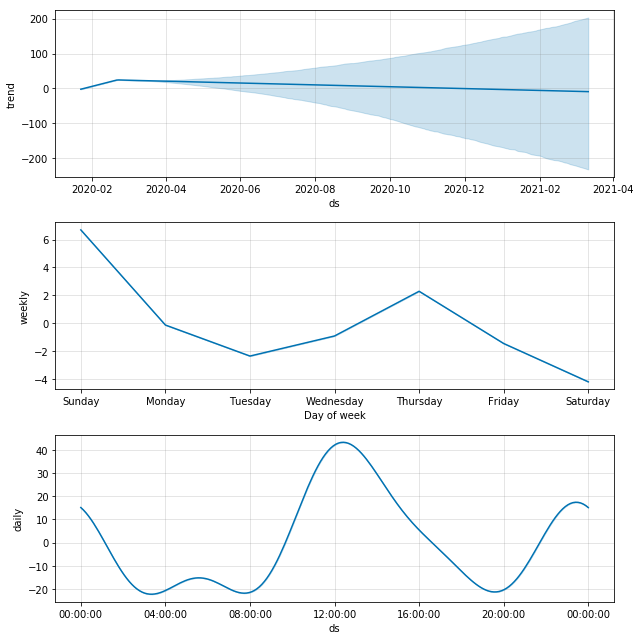

In [28]:
figure_de_recover_3 = model_de_death.plot_components(forecast_de_death)